# 1. Setup environment

In [1]:
# setup env
!pip install -r requirements.txt

In [1]:
# path table-transformer directory 
import os, sys
lib_dir = os.path.join(os.path.abspath(''), "table-transformer")
lib_dir

'D:\\repository\\go5-project\\table_recognition\\table-transformer'

In [2]:
os.getcwd()

'D:\\repository\\go5-project\\table_recognition'

# 2. Load data

 48%|██████████████████████████████████████▍                                         | 48/100 [00:00<00:00, 195.11it/s]


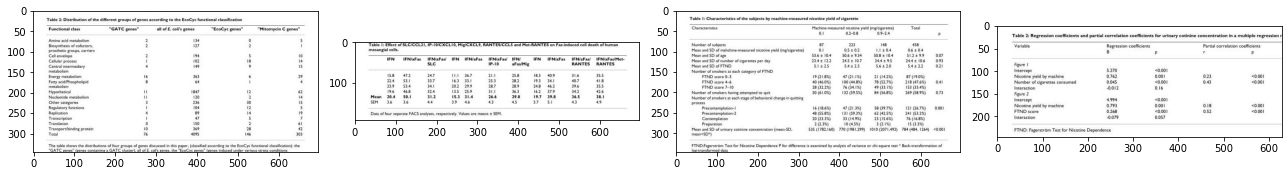

In [4]:
# load data
%matplotlib inline
import matplotlib.pyplot as plt 
import glob
from tqdm import tqdm
import cv2
import os

images = [] # dataset

fig, axs = plt.subplots(1, 4, figsize=(18, 18))
i = 0
for image_path in tqdm(
        glob.glob(os.path.join(os.getcwd(), "debug/images/*.jpg"))[:100],
        total=100,
    ):
    image = cv2.imread(image_path)
    images.append(image)
    if i < 4:
        axs[i].imshow(image)
    i += 1
plt.tight_layout()

In [5]:
# check the number of images
len(images)

48

# 3. Init model

In [6]:
# init structure model
from table_recognition import TableRecognizer
table_recognizer = TableRecognizer(weights_path=os.path.join(lib_dir, "output/pubtables1m_structure_detr_r18.pth"))

{'lr': 5e-05, 'lr_backbone': 1e-05, 'batch_size': 2, 'weight_decay': 0.0001, 'epochs': 20, 'lr_drop': 1, 'lr_gamma': 0.9, 'clip_max_norm': 0.1, 'backbone': 'resnet18', 'num_classes': 6, 'dilation': False, 'position_embedding': 'sine', 'emphasized_weights': {}, 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 125, 'pre_norm': True, 'masks': False, 'aux_loss': False, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'ce_loss_coef': 1, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coef': 0.4, 'set_cost_class': 1, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'device': 'cuda', 'seed': 42, 'start_epoch': 0, 'num_workers': 1, '__module__': 'core', '__dict__': <attribute '__dict__' of 'Args' objects>, '__weakref__': <attribute '__weakref__' of 'Args' objects>, '__doc__': None}
<class 'core.Args'>
----------------------------------------------------------------------------------------------------
loading model
loading model from check

# 4. Infer images

In [7]:
# infer an image
h, w, _ = images[20].shape
table_list_img = [{
    "name": "table",
    "xmin": 0, 
    "xmax": w,
    "ymin": 0,
    "ymax": h
}]
output = table_recognizer.process(images[20], table_list=table_list_img, 
                                  oversegment=0.97, # True or a number in (0, 1]
                                  debug=True)

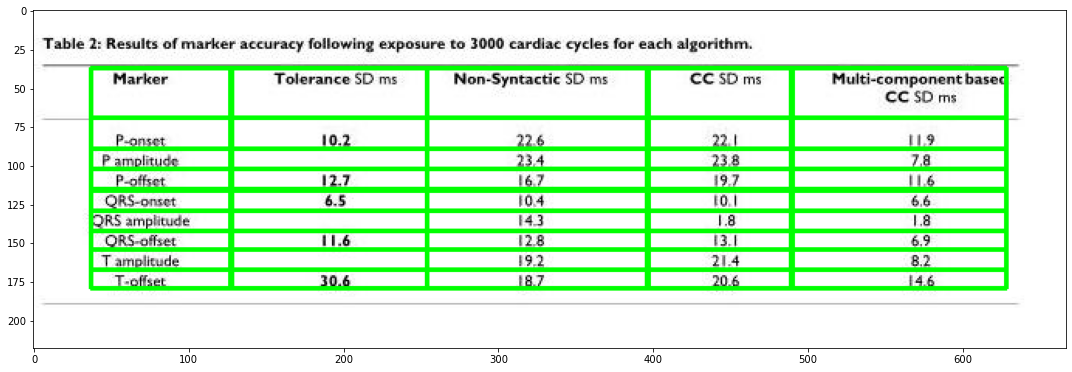

In [8]:
# plot the inference
%matplotlib inline
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(output[0]["debug_image"])
plt.tight_layout()

In [10]:
# infer multiple images
table_lists = [[{
    "name": "table",
    "xmin": 0, 
    "xmax": images[i].shape[1],
    "ymin": 0,
    "ymax": images[i].shape[0]
}] for i in range(len(images))]

id = 0
for i in range(len(table_lists)):
    output = table_recognizer.process(images[i], 
                                      table_list=table_lists[i],
                                      oversegment=0.90,
                                      debug=True)
    for j in range(len(output)):
        if not cv2.imwrite(f"debug/results/pubtables1m-{id}.jpg", output[j]["debug_image"]):
            print("SAVE?")
        else: 
            id += 1

# 5. Evaluate model

In [12]:
# evaluate model on pubtables-1m-structure
import os
import argparse
import json
from datetime import datetime
import sys
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from src.main import *
sys.path.append("../detr")
from engine import evaluate, train_one_epoch
from models import build_model
import util.misc as utils
import datasets.transforms as R

cmd_args = {
    "data_root_dir": "data/pubtables1m/PubTables1M-Structure-PASCAL-VOC",
    "config_file": "src/structure_config.json",
    "backbone": "resnet18",
    "data_type": "structure",
    "model_load_path": "output/pubtables1m_structure_detr_r18.pth",
    "metrics_save_filepath": "",
    "table_words_dir": "",
    "mode": "eval",
    "debug": True,
    "test_max_size": 500
}
config_args = json.load(open(cmd_args["config_file"], "rb"))
config_args.update(cmd_args)
args = type("Args", (object,), config_args)
print(args.__dict__)
print("-" * 100)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

print("loading model")
device = torch.device(args.device)
model, criterion, postprocessors = get_model(args, device)

if args.mode == "train":
    train(args, model, criterion, postprocessors, device)
elif args.mode == "eval":
    eval(args, model, criterion, postprocessors, device)
elif args.mode == "grits":
    assert (
        args.data_type == "structure"
    ), "GriTS is only applicable to structure recognition"
    dataset_test = get_data(args)
    grits(args, model, dataset_test, device)

{'lr': 5e-05, 'lr_backbone': 1e-05, 'batch_size': 2, 'weight_decay': 0.0001, 'epochs': 20, 'lr_drop': 1, 'lr_gamma': 0.9, 'clip_max_norm': 0.1, 'backbone': 'resnet18', 'num_classes': 6, 'dilation': False, 'position_embedding': 'sine', 'emphasized_weights': {}, 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 125, 'pre_norm': True, 'masks': False, 'aux_loss': False, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'ce_loss_coef': 1, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coef': 0.4, 'set_cost_class': 1, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'device': 'cuda', 'seed': 42, 'start_epoch': 0, 'num_workers': 1, 'data_root_dir': 'data/pubtables1m/PubTables1M-Structure-PASCAL-VOC', 'config_file': 'src/structure_config.json', 'data_type': 'structure', 'model_load_path': 'output/pubtables1m_structure_detr_r18.pth', 'metrics_save_filepath': '', 'table_words_dir': '', 'mode': 'eval', 'debug': True, 'test_max_size': 500, '__